/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 67s 36ms/step - loss: 176653.1094 - val_loss: 9787.9150
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 87s 39ms/step - loss: 9422.2041 - val_loss: 3909.6646
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 74s 34ms/step - loss: 6591.5210 - val_loss: 3650.6692
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - loss: 6360.4844 - val_loss: 3541.5537
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - loss: 6223.7212 - val_loss: 3261.6279
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - loss: 6197.0703 - val_loss: 3213.3372
Epoch 7/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 80s 34ms/step - loss: 5656.1528 - val_loss: 3489.5405
Epoch 8/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - loss: 5653.1260 - val_loss: 3145.3606
Epoch 9/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 82s 35ms/step - loss: 5605.3140 - val_loss: 3017.1611
Epoch 10/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - loss: 5444.8970 - val_loss: 4341.0371
Epoch 11/30
1719/1719 ━━━━━━━━━━━━━━━

430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step


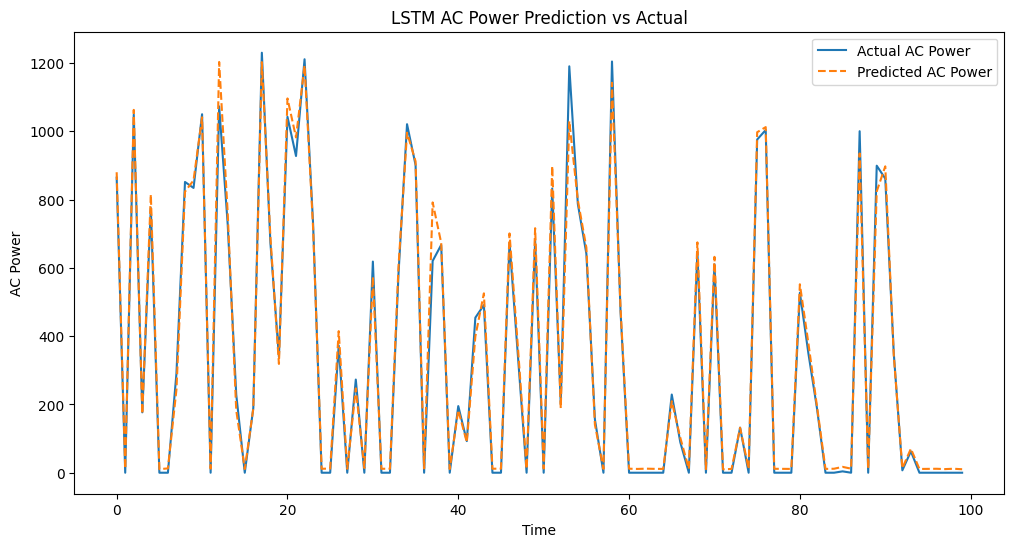

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load dataset
generation_data = pd.read_csv("/content/Plant_1_Generation_Data.csv")

# Convert DATE_TIME to datetime format
generation_data["DATE_TIME"] = pd.to_datetime(generation_data["DATE_TIME"], dayfirst=True, errors='coerce')

# Feature Engineering
generation_data["Hour"] = generation_data["DATE_TIME"].dt.hour
generation_data["Day"] = generation_data["DATE_TIME"].dt.day
generation_data["Month"] = generation_data["DATE_TIME"].dt.month

# Select Features (only from generation data)
features = ["DC_POWER", "DAILY_YIELD", "TOTAL_YIELD", "Hour", "Day", "Month"]
target = "AC_POWER"

# Drop missing values
generation_data.dropna(subset=features + [target], inplace=True)

# Scaling Data
scaler = MinMaxScaler()
generation_data[features] = scaler.fit_transform(generation_data[features])

# Save the scaler for future use
joblib.dump(scaler, "scaler.pkl")

# Prepare data for LSTM
lookback = 24  # Using past 24 hours of data to predict next hour
X, y = [], []
for i in range(lookback, len(generation_data)):
    X.append(generation_data[features].iloc[i - lookback:i].values)
    y.append(generation_data[target].iloc[i])
X, y = np.array(X), np.array(y)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LSTM Model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(lookback, len(features))),
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train LSTM
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)

# Save the trained model
model.save("lstm_solar_model.h5")

# Predictions
lstm_predictions = model.predict(X_test)

# Visualizing Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label="Actual AC Power")
plt.plot(lstm_predictions[:100], label="Predicted AC Power", linestyle="dashed")
plt.legend()
plt.xlabel("Time")
plt.ylabel("AC Power")
plt.title("LSTM AC Power Prediction vs Actual")
plt.show()
